## self organizing maps project description

The goal is to identify the leading patterns of geopotential height for two forms of land-atmosphere feedbacks, dry coupling afternoon precipitation events and wet coupling afternoon precipitation events, in order to determine whether there are large-scale factors which create the preconditions to support these land-surface feedbacks. 

In [1]:
import pandas as pd
import textwrap
from datetime import date
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import glob
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import os
import re
from matplotlib.ticker import FormatStrFormatter
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from matplotlib.patches import Rectangle
from pydoc import help
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
with open('geosom.pdkl', 'rb') as f:
    
    geosom = pickle.load(f)

geosom.rename_axis('day', axis='index', inplace=True)

geosom.reset_index(inplace=True)

geosom.rename(columns={'daily_mean': 'z500'}, inplace=True)

geosom_dry_apes = geosom[(geosom['APE']==True) & (geosom['dry_coupling']==True)]

geosom_wet_apes = geosom[(geosom['APE']==True) & (geosom['wet_coupling']==True)]

geosom_dry_coup = geosom[geosom['dry_coupling']==True]

geosom_wet_coup = geosom[geosom['wet_coupling']==True]

## Below: choose which df to train SOM on

In [3]:
df = geosom_dry_apes

title = "Dry APE"

features = df[['day','lat','lon','std_anomaly']]

In [4]:
#restructuring features such that there is a unique combination of latitude and longitude as its own column
#so that there is one row for each day 
#latitude range: 25 --> 50, longitude range: 70 --> 120

X_feat = features.pivot_table(index='day', columns=['lat', 'lon'], values=['std_anomaly'])

X_feat.reset_index(inplace=True)

#flattening the MultiIndex column names

X_feat.columns = [''.join(map(str, col)) for col in X_feat.columns]

X = X_feat.iloc[:, 1:].values

#after restructuring features into X_feat, combining into a single dataframe for later use
#data has shape 160 x 1329 (160 days, 1329 latitude, longitude pairs)
# data = pd.merge(X_feat, labels_df, on='day', how='inner')
print(X_feat.shape)

(91, 2081)


In [5]:
X_feat.shape

(91, 2081)

In [6]:
# calculated standardized anamolies: x - mean (of feature)/standard deviation (of feature)
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)

In [7]:
# hyperparameter options
#although 30 x 30 created a very small QE, the SOM was too large for my dataset which resulted in overfitting

random_seed = 42

np.random.seed(random_seed)

param_grid = {
    'x': [2],
    'y': [2],
    'learning_rate': [0.01, 0.1, 0.25, 0.5, 1],
    'sigma': [0.1, 0.5, 1.0, 1.5, 2]
}

# all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# initialize variables to track the best configuration
best_params = None

best_quantization_error = float('inf')

# function to calculate quantization error: measures the average distance between each data point and its corresponding BMU in the SOM

def quantization_error(som, data):
    
    error = 0
    
    for x in data:
        
        #difference between x (from x_scaled) and weights for the winning node, then take the norm of that vector to get the total distance
        error += np.linalg.norm(x - som.get_weights()[som.winner(x)])
    
    #for each SOM, calculate the average QE
    return error / len(data)

# # grid search

for params in grid:
    
    som = MiniSom(x=params['x'], y=params['y'], input_len=X.shape[1], sigma=params['sigma'], learning_rate=params['learning_rate'], random_seed=random_seed)
    
    som.random_weights_init(X)
    
    som.train_random(data=X, num_iteration=10000)
    
    qe = quantization_error(som, X)
    
    print(f"Params: {params}, Quantization Error: {qe}")
    
    #best_quantization_error starts at infinity, then with each subsequent QE calculation, updates best QE & params if new QE is less than previous QE 
    
    if qe < best_quantization_error:
        
        best_quantization_error = qe
        
        best_params = params

print(f"Best params: {best_params}, Best Quantization Error: {best_quantization_error}")


Params: {'learning_rate': 0.01, 'sigma': 0.1, 'x': 2, 'y': 2}, Quantization Error: 38.78535820906505
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 2, 'y': 2}, Quantization Error: 38.10109322779713
Params: {'learning_rate': 0.01, 'sigma': 1.0, 'x': 2, 'y': 2}, Quantization Error: 37.8031161212964
Params: {'learning_rate': 0.01, 'sigma': 1.5, 'x': 2, 'y': 2}, Quantization Error: 38.5106099561403
Params: {'learning_rate': 0.01, 'sigma': 2, 'x': 2, 'y': 2}, Quantization Error: 40.08314005908207
Params: {'learning_rate': 0.1, 'sigma': 0.1, 'x': 2, 'y': 2}, Quantization Error: 37.95117013962658
Params: {'learning_rate': 0.1, 'sigma': 0.5, 'x': 2, 'y': 2}, Quantization Error: 37.95072699413381
Params: {'learning_rate': 0.1, 'sigma': 1.0, 'x': 2, 'y': 2}, Quantization Error: 37.948632249480916
Params: {'learning_rate': 0.1, 'sigma': 1.5, 'x': 2, 'y': 2}, Quantization Error: 38.36968375319258
Params: {'learning_rate': 0.1, 'sigma': 2, 'x': 2, 'y': 2}, Quantization Error: 39.771150701169574

In [8]:
np.random.seed(42)

n_rows = best_params['x']

n_columns = best_params['y']

sigma = best_params['sigma']

learning_rate = best_params['learning_rate']

som = MiniSom(n_rows, n_columns, X.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=42)

som.random_weights_init(X)

#add verbose = True if you want more detail

som.train_random(X, 10000)

In [9]:
# creating a bmu column to assign each day to the bmu according to SOM result

data = pd.DataFrame(X_feat)

bmus = []

for x in X:
    
    bmu = som.winner(x)
    
    bmus.append(bmu)
    
data['bmu'] = bmus
data.shape

(91, 2082)

## Plotting SOM with Cartopy --> full result

In [10]:
# max_z500_som = np.max(som.get_weights())

# min_z500_som = np.min(som.get_weights())

# max_abs_z500 = max(abs(max_z500_som), abs(min_z500_som))

# Set the color bar limits to be symmetric around 0
color_bar_max_z500 = 1.6

color_bar_min_z500 = -1.6

weights = som.get_weights()

som_dim_x, som_dim_y, num_features = weights.shape

sgp_lon_min, sgp_lon_max = 262-2, 263+2

sgp_lat_min, sgp_lat_max = 36-2, 37+2

latitude_size_z500 = 26

longitude_size_z500 = 80

latitudes_z500 = np.linspace(25, 50, latitude_size_z500)

longitudes_z500 = np.linspace(220, 299, longitude_size_z500)

lon_z500, lat_z500 = np.meshgrid(longitudes_z500, latitudes_z500)

norm = TwoSlopeNorm(vmin=color_bar_min_z500, vcenter=0, vmax=color_bar_max_z500)

total_samples = len(X)

grid_size = int(np.ceil(np.sqrt(som_dim_x * som_dim_y)))

frequency_map = np.zeros((som_dim_x, som_dim_y))

for x in X:
    
    w = som.winner(x)
    
    frequency_map[w] += 1

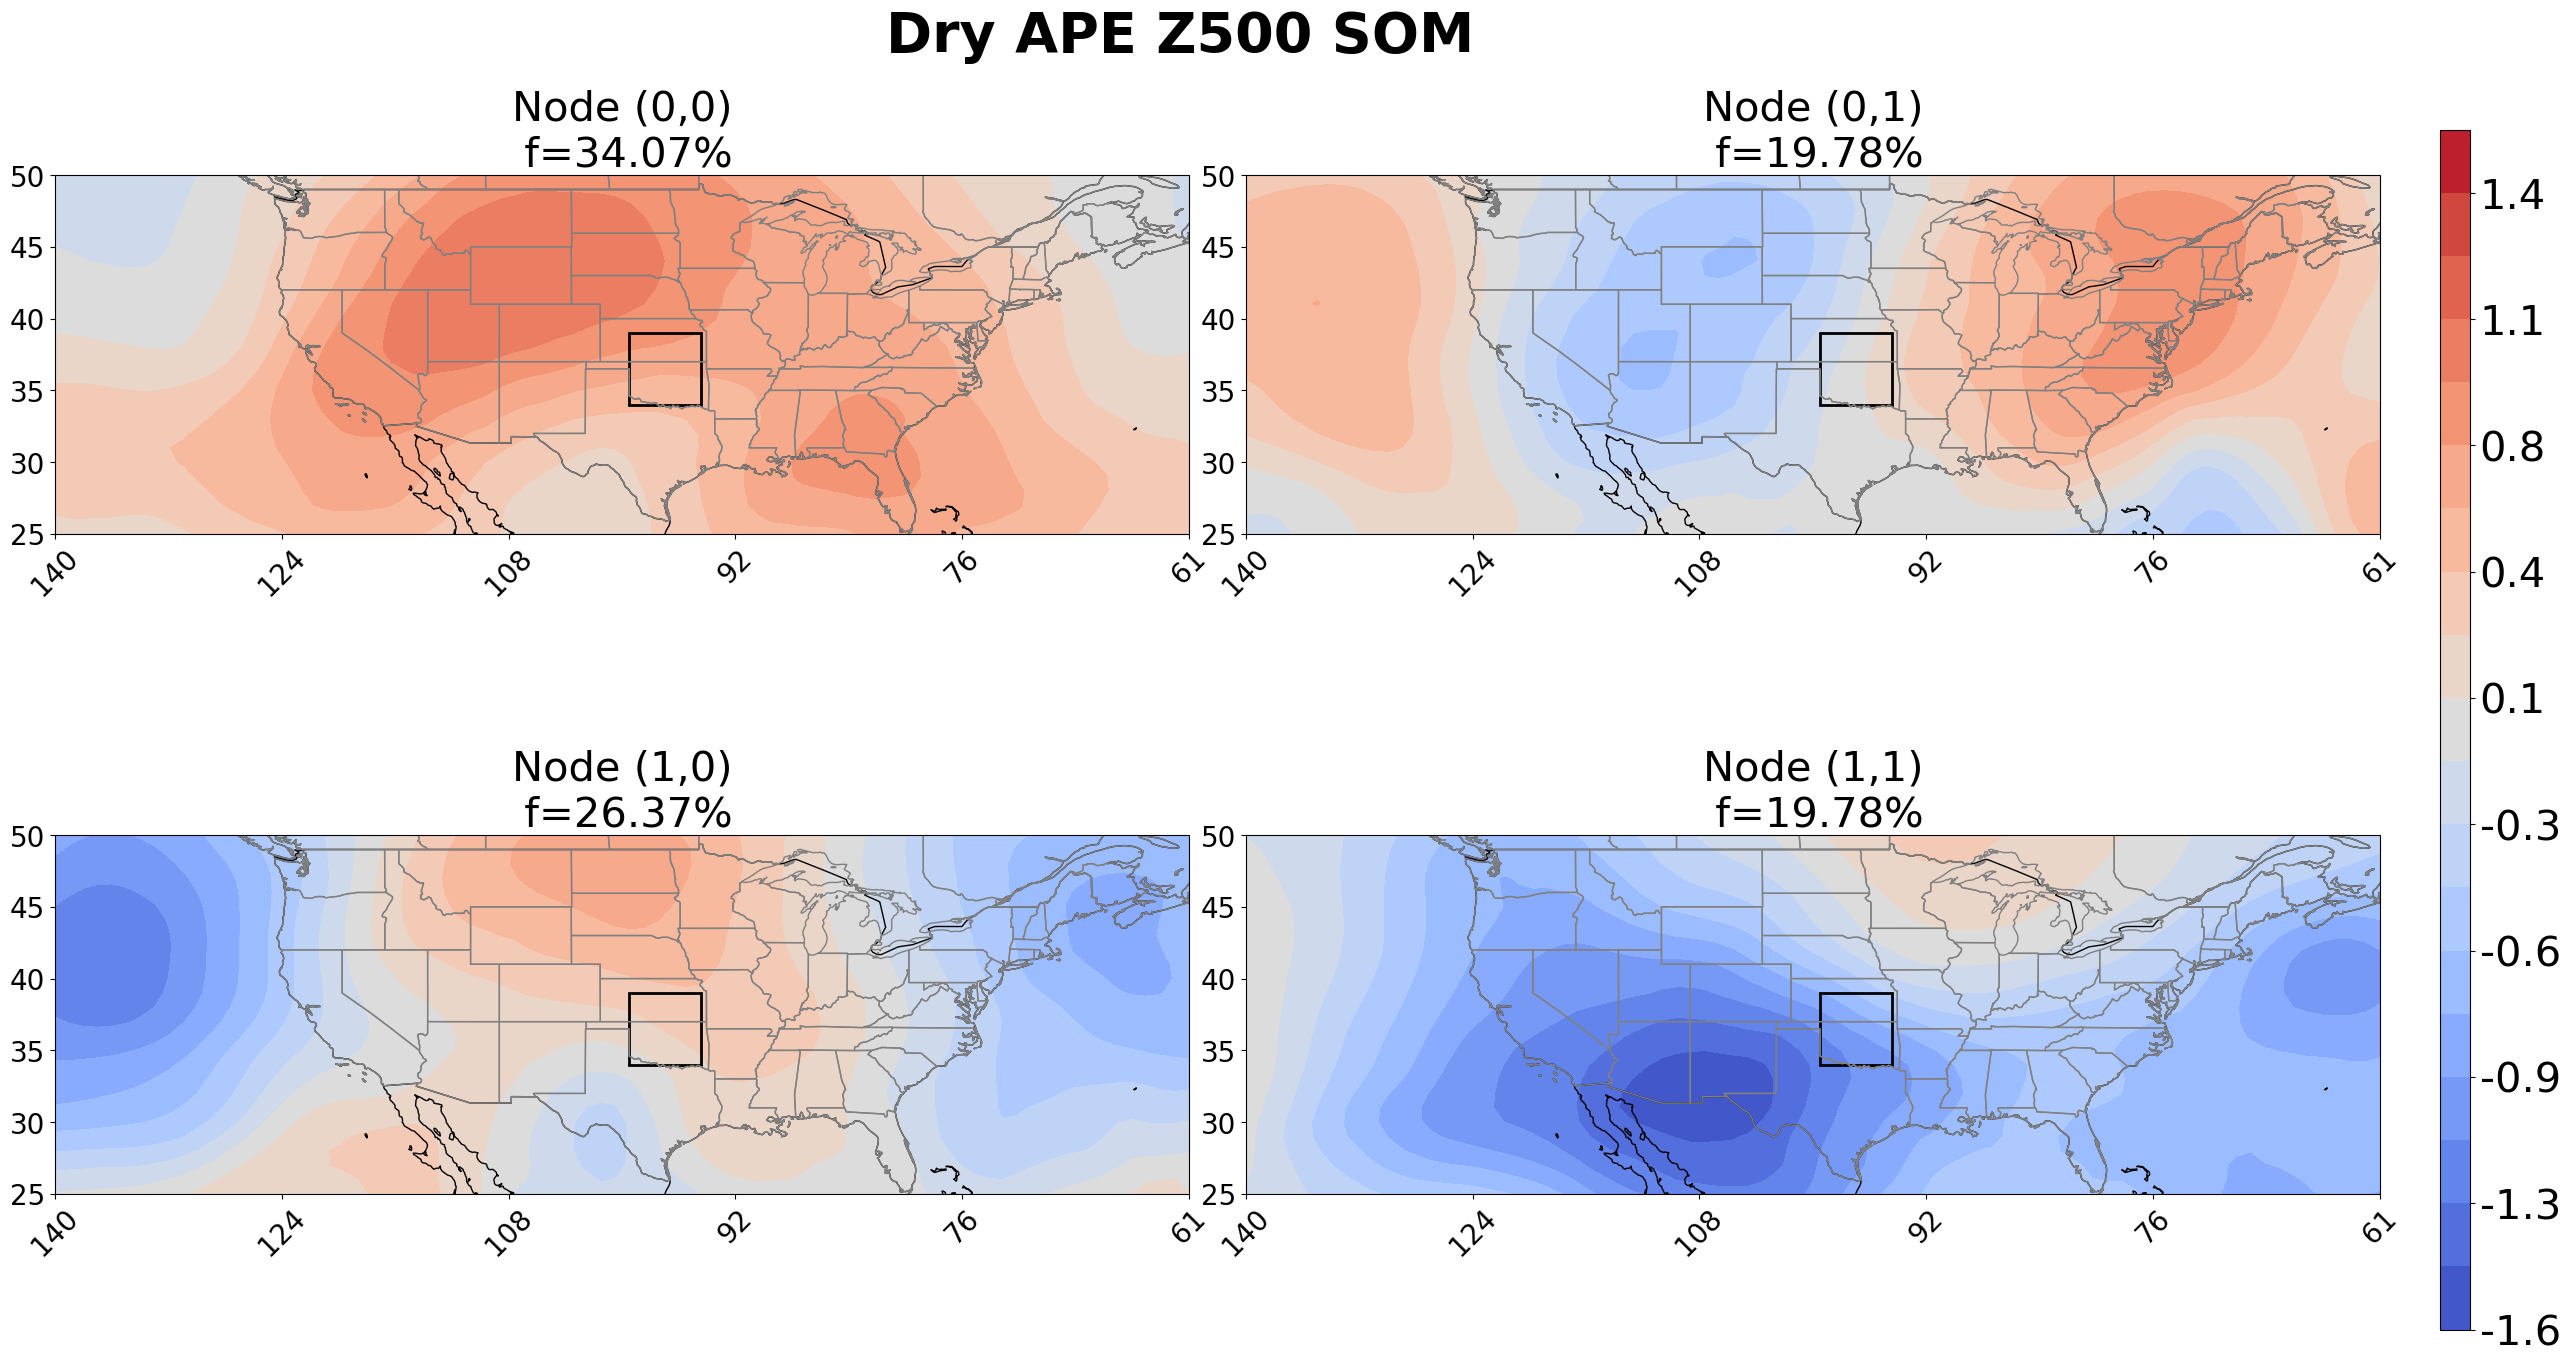

In [11]:
fig = plt.figure(figsize=(30, 15))

gs = GridSpec(som_dim_x, som_dim_y, figure=fig, height_ratios=np.ones(som_dim_x), width_ratios=np.ones(som_dim_y), wspace=0.05, hspace=0.1)

for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        
        ax.set_extent([220, 299, 25, 50], crs=ccrs.PlateCarree())

        # Reshape the weight vector back into the original grid shape
        geopotential_height = weights[i, j, :].reshape((latitude_size_z500, longitude_size_z500))
        
        #ax.contourf(x, y, data, ....)
        cont = ax.contourf(lon_z500, lat_z500, geopotential_height, cmap='coolwarm', levels=np.linspace(color_bar_min_z500, color_bar_max_z500, 20), norm=norm)

        # add geography
        ax.add_feature(cfeature.COASTLINE)
        
        ax.add_feature(cfeature.BORDERS)
        
        ax.add_feature(cfeature.STATES, edgecolor='gray')

        # Calculate the frequency of each BMU percentage
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100

        ax.set_title(f'Node ({i},{j})\n f={frequency_percentage:.2f}%', fontsize=30)

        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, 
                            sgp_lat_max - sgp_lat_min, edgecolor='black', 
                            facecolor='none', linewidth=2, transform=ccrs.PlateCarree())

        ax.add_patch(sgp_box)
        
        ax.set_xticks(np.linspace(-140, -61, 6))  # Set longitude ticks
        
        ax.set_yticks(np.linspace(25, 50, 6))   # Set latitude ticks
        
        ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=20)
        
        ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=20)

# create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.1, 0.01, 0.8])

cbar = fig.colorbar(cont, cax=cax, orientation='vertical')

# Set colorbar tick labels font size
cbar.ax.tick_params(labelsize=30)

cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.subplots_adjust(top=0.95)

plt.suptitle("{} Z500 SOM".format(title), fontsize=40, fontweight='bold')

plt.show()

## Plotting IVT composite per SOM --> full result

In [12]:
#reading in IVT information to create composite with SOM result

with open('ivt_flat.pdkl', 'rb') as f:
    
    daily_ivt = pickle.load(f)
    
#creating df which only includes day and bmu for IVT composite
bmu_per_day = data.set_index("day")

bmu_per_day = bmu_per_day['bmu']

#merge bmu & ivt
daily_ivt_with_bmu = pd.merge(daily_ivt, bmu_per_day, left_index=True, right_index=True)

daily_ivt_with_bmu.shape

(91, 2081)

In [13]:
with open('quv_profiles.pdkl', 'rb') as file:
    
    quv_profiles = pickle.load(file)

quv_profiles = quv_profiles[['afternoon','all_hours','meanLTq','APE','interp_pres','q_obs','interp_alt','u_profiles','v_profiles','q_profiles','dry_coupling','wet_coupling']]

daily_ivt_with_bmu = pd.merge(daily_ivt_with_bmu, quv_profiles, left_index=True, right_index=True, how='left')

In [14]:
daily_ivt_with_bmu.shape

(91, 2093)

In [15]:
# global_min_ivt = float('inf')

# global_max_ivt = float('-inf')

# all_bmus = daily_ivt_with_bmu['bmu'].values

# for bmu in all_bmus:
    
#     bmu_data = daily_ivt_with_bmu[daily_ivt_with_bmu['bmu'] == bmu]
    
#     mean_ivt = bmu_data.iloc[:, :-13].mean()
    
#     global_min_ivt = min(global_min_ivt, mean_ivt.min())
    
#     global_max_ivt = max(global_max_ivt, mean_ivt.max())

# max_abs_ivt = max(abs(global_min_ivt), abs(global_max_ivt))

# Set the color bar limits to be symmetric around 0
color_bar_max_ivt = 1.5

color_bar_min_ivt = -1.5

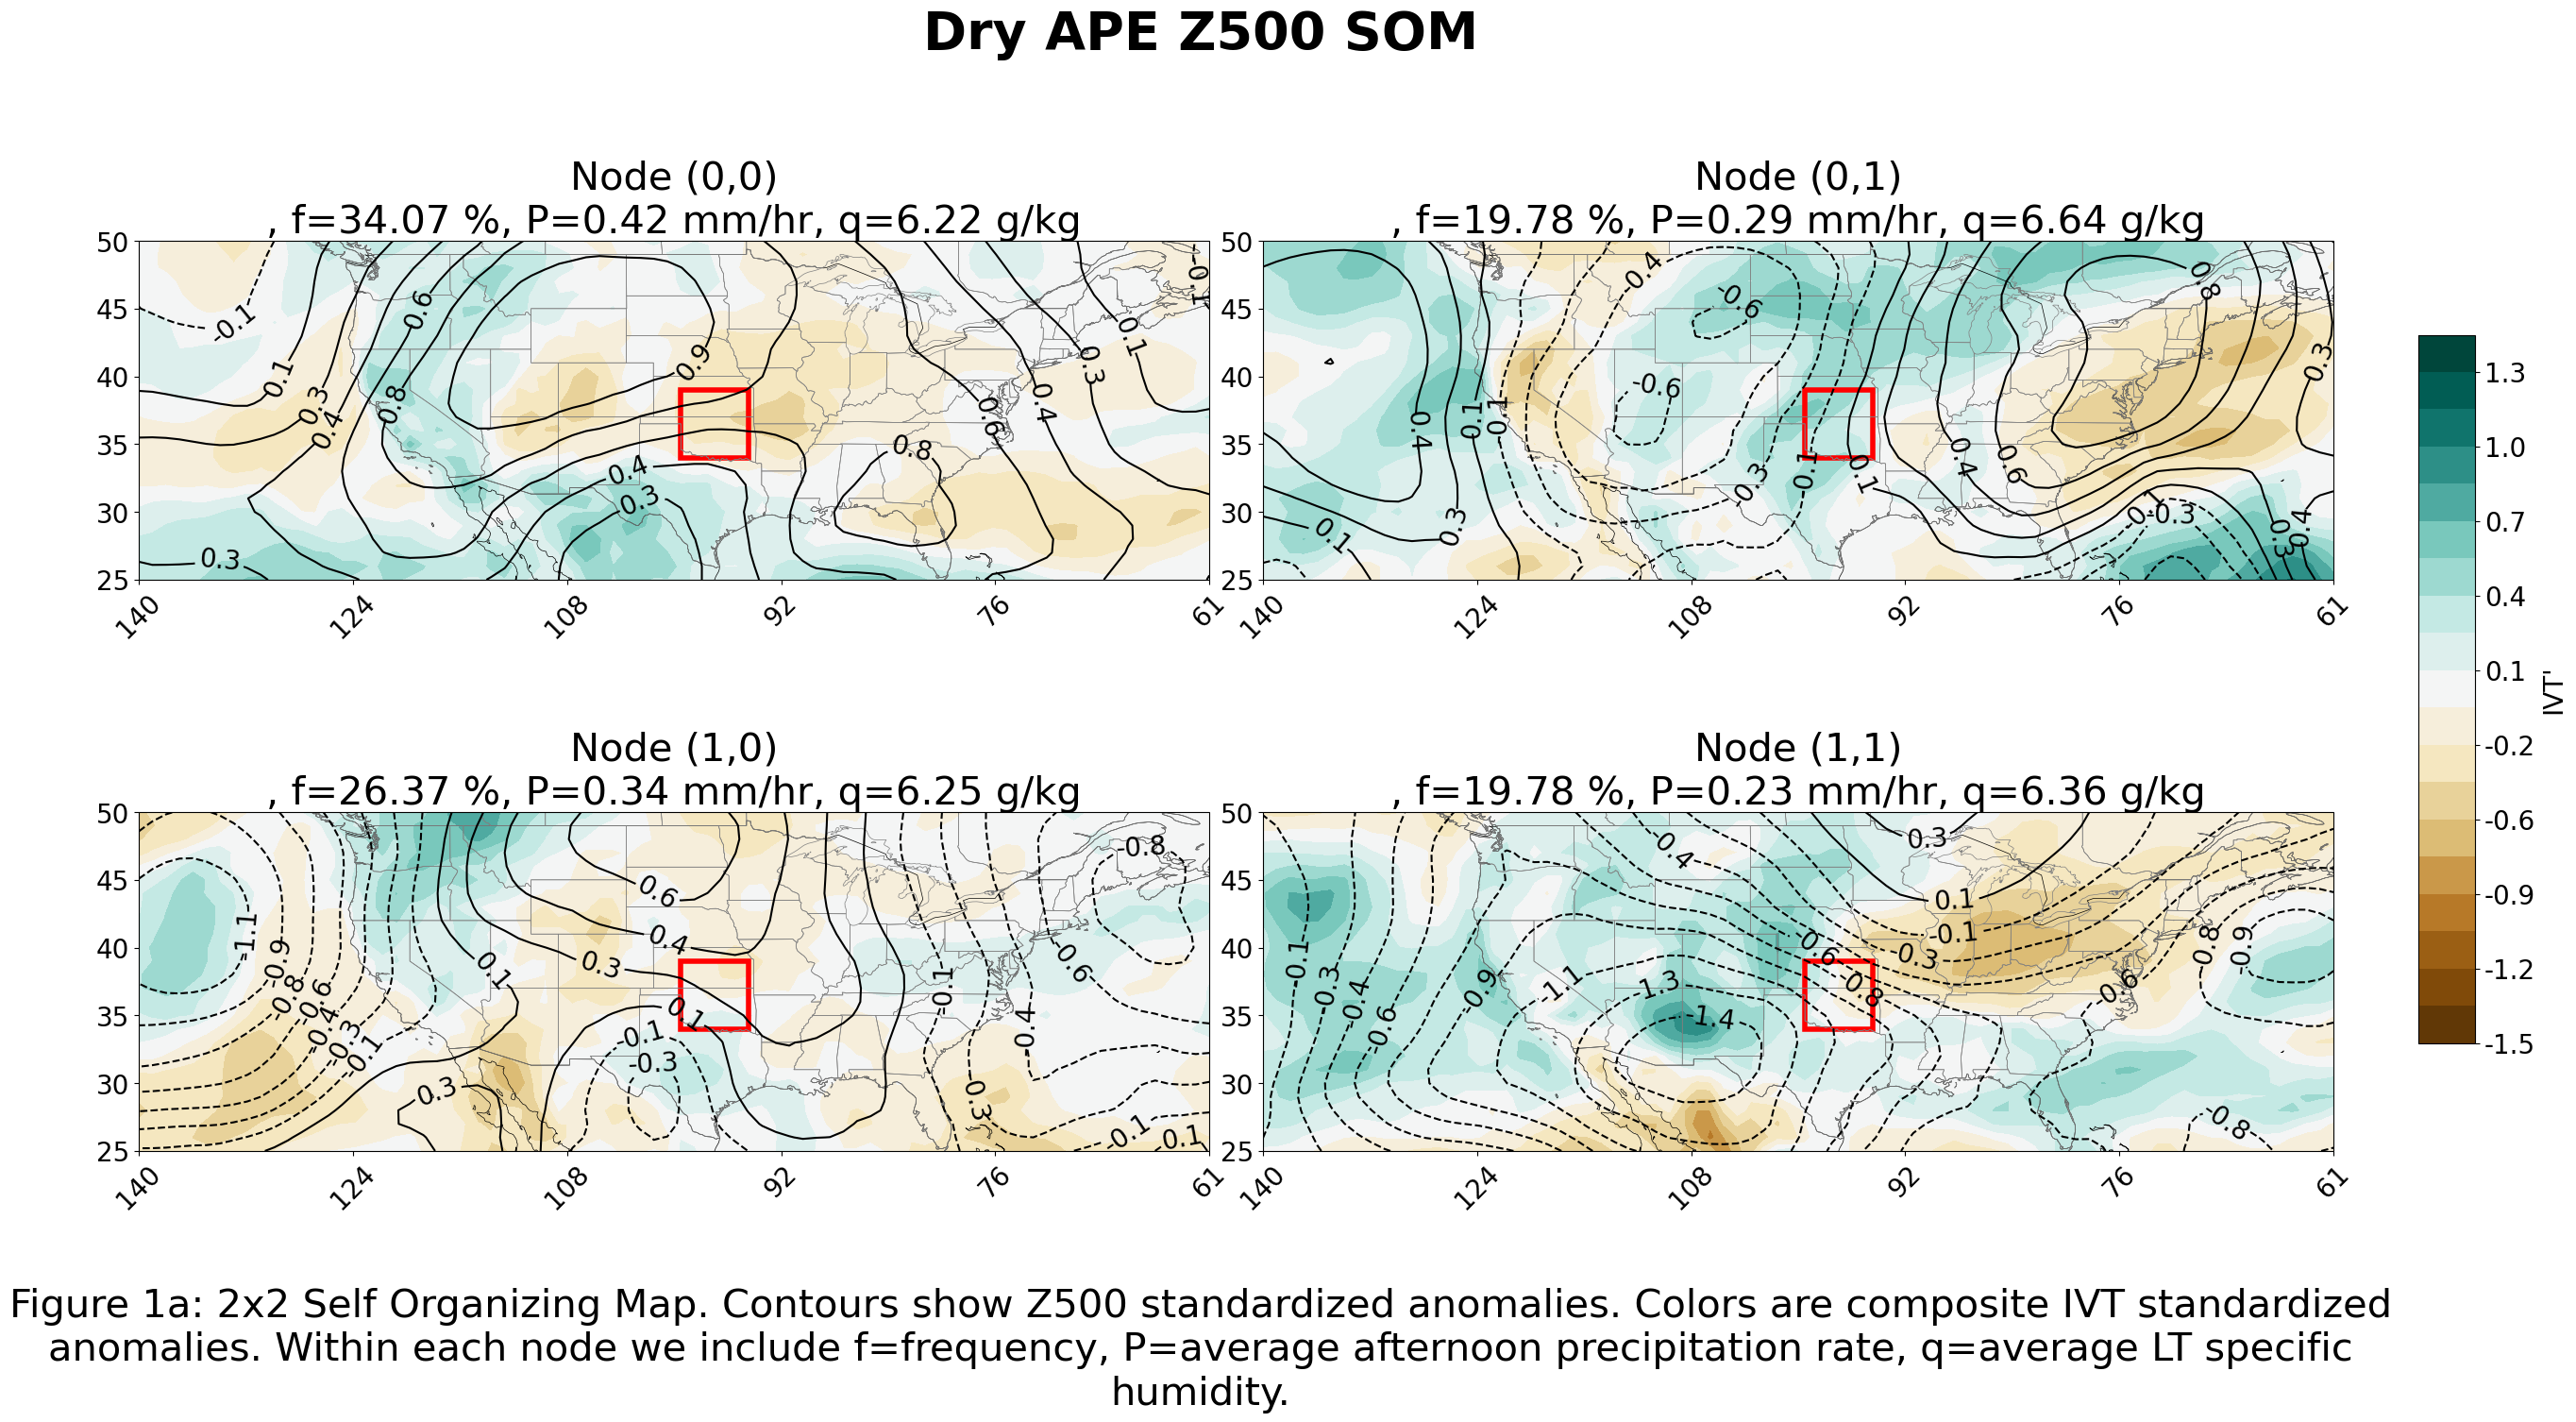

In [16]:
# Set color normalization for IVT data

norm_ivt = TwoSlopeNorm(vmin=color_bar_min_ivt, vcenter=0, vmax=color_bar_max_ivt)

fig = plt.figure(figsize=(30, 15))

gs = GridSpec(som_dim_x, som_dim_y, figure=fig, height_ratios=np.ones(som_dim_x), width_ratios=np.ones(som_dim_y), wspace=0.05, hspace=0.1)

fig.suptitle("{} Z500 SOM".format(title), fontsize=40, fontweight='bold', y=0.98)

for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        
        ax.set_extent([220, 299, 25, 50], crs=ccrs.PlateCarree())
        
        # Z500 data - contour
        geopotential_height = weights[i, j, :].reshape((latitude_size_z500, longitude_size_z500))
        
        cont_z500 = ax.contour(lon_z500, lat_z500, geopotential_height, colors='black', levels=np.linspace(color_bar_min_z500, color_bar_max_z500, 20))
        
        ax.clabel(cont_z500, fmt='%1.1f', fontsize=20)

        # Update linestyle for negative contours to dashed
        for index, level in enumerate(cont_z500.levels):
            
            if level < 0:
                
                cont_z500.collections[index].set_linestyle('dashed')

        # IVT data - filled contour
        bmu_data = daily_ivt_with_bmu[daily_ivt_with_bmu['bmu'] == (i, j)]
        
        mean_ivt = bmu_data.iloc[:, :-13].mean().values.reshape((latitude_size_z500, longitude_size_z500))
        
        mean_afternoon_precip = (bmu_data['afternoon']/6).mean()
        
        mean_sgp_lt = (bmu_data['meanLTq']).mean()
        
#         ape_count = (bmu_data[bmu_data['APE']==True].shape[0]/bmu_data.shape[0])*100

        cont_ivt = ax.contourf(lon_z500, lat_z500, mean_ivt, cmap='BrBG', levels=np.linspace(color_bar_min_ivt, color_bar_max_ivt, 20), norm=norm_ivt)

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        
        ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
        
        # Frequency and title
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100
        
        ax.set_title(f'Node ({i},{j})\n, f={frequency_percentage:.2f} %, P={mean_afternoon_precip:.2f} mm/hr, q={mean_sgp_lt:.2f} g/kg', fontsize=30)
        
        # SGP box
        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                            edgecolor='red', facecolor='none', linewidth=4, transform=ccrs.PlateCarree())
        
        ax.add_patch(sgp_box)
        
        # Axis ticks
        ax.set_xticks(np.linspace(-140, -61, 6))
        
        ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=20)
        
        ax.set_yticks(np.linspace(25, 50, 6))
        
        ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=20)
    

# IVT colorbar spanning the full figure height
cax_ivt = fig.add_axes([0.93, 0.25, 0.02, 0.5])  # Adjust these values to control position and size

cbar_ivt = fig.colorbar(cont_ivt, cax=cax_ivt, orientation='vertical')

cbar_ivt.set_label("IVT'", fontsize=20)

cbar_ivt.ax.tick_params(labelsize=20)

cbar_ivt.ax.tick_params(labelsize=20)

cbar_ivt.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout(rect=[0, 0, 0.94, 0.96])

caption = "Figure 1a: 2x2 Self Organizing Map. Contours show Z500 standardized anomalies. Colors are composite IVT standardized anomalies. Within each node we include f=frequency, P=average afternoon precipitation rate, q=average LT specific humidity."

wrapped_caption = "\n".join(textwrap.wrap(caption, width=120))

plt.figtext(0.5, -0.005, wrapped_caption, ha='center', fontsize=30)

plt.show()


## LT humidity anomalies with SOM

In [17]:
#reading in LTq information to create composite with SOM result

with open('ltq_dryapes.pdkl', 'rb') as f:
    
    ltq_dryapes = pickle.load(f)
    
with open('ltq_wetapes.pdkl', 'rb') as f:
    
    ltq_wetapes = pickle.load(f)

In [18]:
#merge bmu & ivt

ltq_dry_bmu = pd.merge(ltq_dryapes, bmu_per_day, left_index=True, right_index=True)

ltq_wet_bmu = pd.merge(ltq_wetapes, bmu_per_day, left_index=True, right_index=True)

In [19]:
#adding back in meanLTq & precipitation rate &

ltq_dry_bmu = pd.merge(ltq_dry_bmu, quv_profiles, left_index=True, right_index=True)

ltq_wet_bmu = pd.merge(ltq_wet_bmu, quv_profiles, left_index=True, right_index=True)

set as dry or wet depending on whats being trained

In [20]:
dfq = ltq_dry_bmu

dfq.shape

(91, 24354)

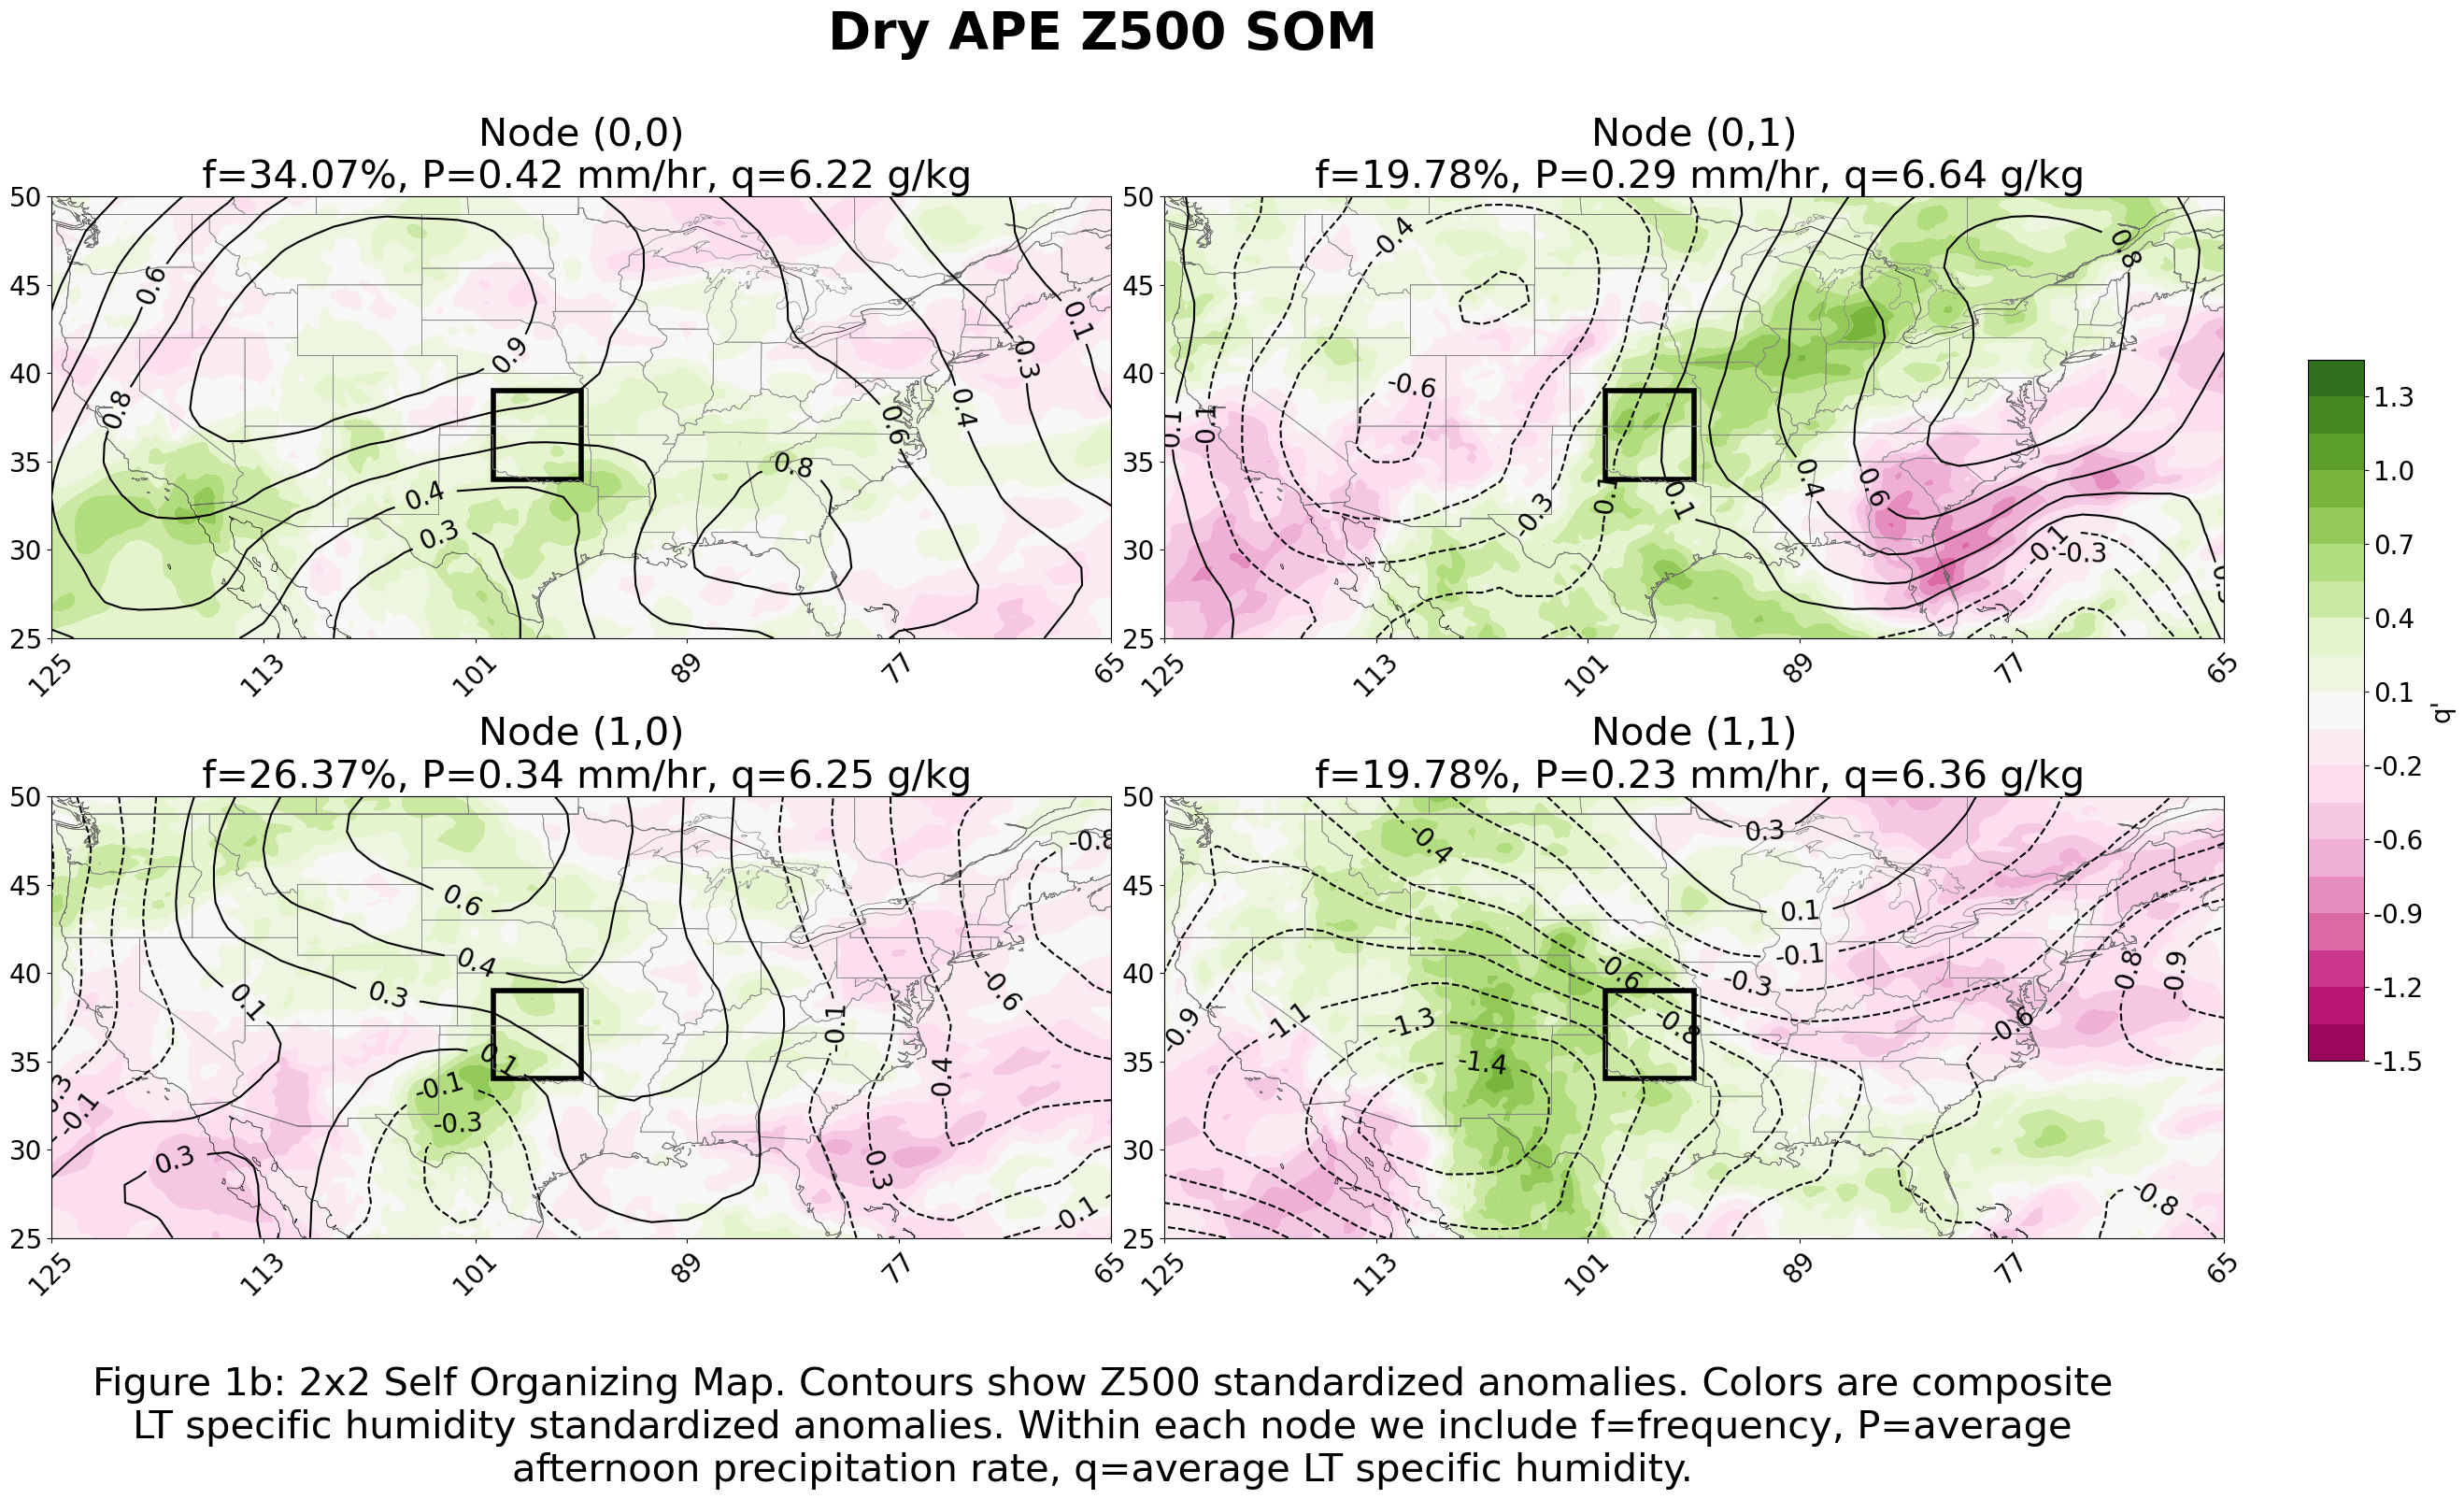

In [21]:
# Set color normalization for IVT data

lat_q = np.arange(25.0, 50.25, 0.25)

lon_q = np.arange(-125, -64.75, 0.25)

x_min = np.min(lon_q)  # Minimum longitude

x_max = np.max(lon_q)   # Maximum longitude

latitude_size_q = len(lat_q)

longitude_size_q = len(lon_q)

latitude_size_z500 = 26

longitude_size_z500 = 80

latitudes_z500 = np.linspace(25, 50, latitude_size_z500)

longitudes_z500 = np.linspace(220, 299, longitude_size_z500)

lon_z500, lat_z500 = np.meshgrid(longitudes_z500, latitudes_z500)

color_bar_max_lt = 1.5

color_bar_min_lt = -1.5

fig = plt.figure(figsize=(30, 15))

fig.suptitle("{} Z500 SOM".format(title), fontsize=40, fontweight='bold', y=1)

gs = GridSpec(som_dim_x, som_dim_y, figure=fig, height_ratios=np.ones(som_dim_x), width_ratios=np.ones(som_dim_y), wspace=0.05, hspace=0.25)

for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        
        bmu_data = dfq[dfq['bmu'] == (i, j)]
        
        # Z500 data - contour
        geopotential_height = weights[i, j, :].reshape((latitude_size_z500, longitude_size_z500))
        
        cont_z500 = ax.contour(lon_z500, lat_z500, geopotential_height, colors='black', levels=np.linspace(color_bar_min_z500, color_bar_max_z500, 20))
        
        ax.clabel(cont_z500, fmt='%1.1f', fontsize=20)
        
        mean_q = bmu_data.iloc[:, :-13].mean().values.reshape((latitude_size_q, longitude_size_q))
        
        mean_q = np.asarray(mean_q, dtype=np.float64)

        contq = ax.contourf(lon_q, lat_q, mean_q, levels=np.linspace(color_bar_min_lt, color_bar_max_lt, 20), cmap='PiYG')
        
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100

        mean_sgp_lt = (bmu_data['meanLTq']).mean()
        
        mean_afternoon_precip = (bmu_data['afternoon']/6).mean()

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        
        ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
        
        # SGP box
        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                            edgecolor='black', facecolor='none', linewidth=4, transform=ccrs.PlateCarree())
        
        ax.add_patch(sgp_box)
    
        ax.set_title(f'Node ({i},{j})\n f={frequency_percentage:.2f}%, P={mean_afternoon_precip:.2f} mm/hr, q={mean_sgp_lt:.2f} g/kg', fontsize=30)
        
        ax.set_xlim(x_min, x_max)
        
        # Axis ticks
        ax.set_xticks(np.linspace(x_min, x_max, 6))
        
        ax.set_xticklabels(np.linspace(-x_min, -x_max, 6).astype(int), rotation=45, fontsize=20)
        
        ax.set_yticks(np.linspace(25, 50, 6))
        
        ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=20)
        
cax_q = fig.add_axes([0.93, 0.25, 0.02, 0.5])  # Adjust these values to control position and size

cbar_q = fig.colorbar(contq, cax=cax_q, orientation='vertical')

cbar_q.set_label("q'", fontsize=20)

cbar_q.ax.tick_params(labelsize=20)

cbar_q.ax.tick_params(labelsize=20)

cbar_q.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout(rect=[0, 0, 0.94, 0.96])

caption = "Figure 1b: 2x2 Self Organizing Map. Contours show Z500 standardized anomalies. Colors are composite LT specific humidity standardized anomalies. Within each node we include f=frequency, P=average afternoon precipitation rate, q=average LT specific humidity."

wrapped_caption = "\n".join(textwrap.wrap(caption, width=100))

plt.figtext(0.5, -0.05, wrapped_caption, ha='center', fontsize=30)

plt.show()


## humidity and wind profiles for each node

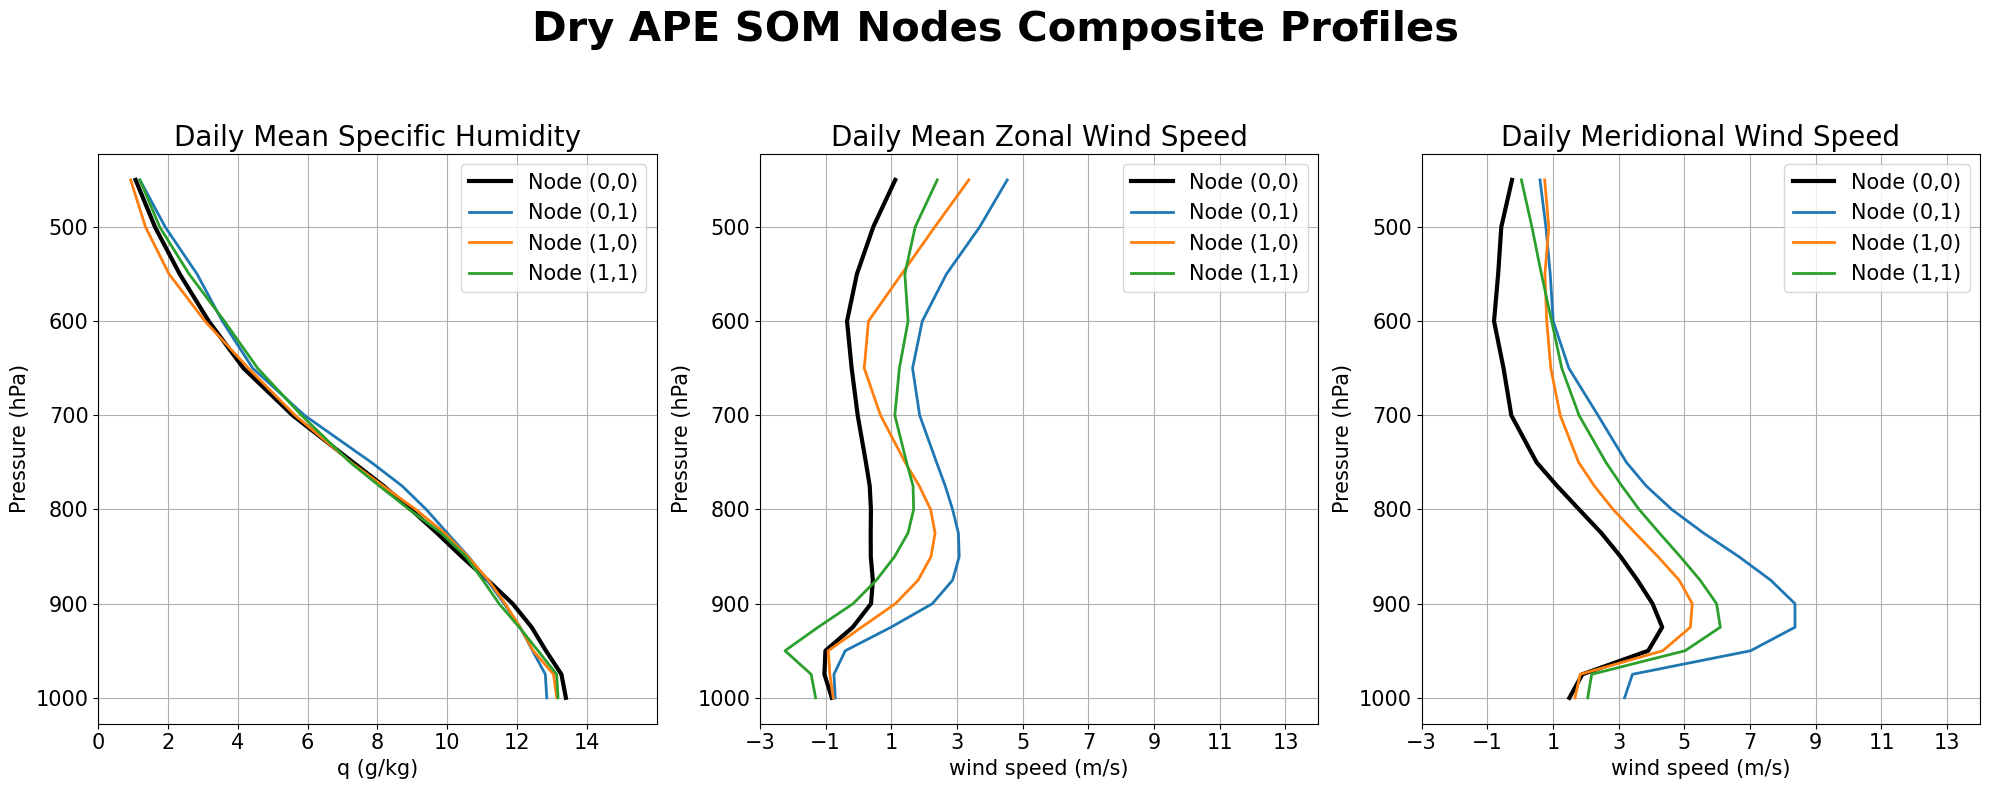

In [22]:
def composite_profile(arrays):
    
    return np.nanmean(arrays.tolist(), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

y_axis = np.array([50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
                               400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825,
                               850, 875, 900, 925, 950, 975, 1000])[12:]

# Loop through each node in the SOM grid
for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        # Filter data for the current node
        bmu_data = daily_ivt_with_bmu[daily_ivt_with_bmu['bmu'] == (i, j)]

        # Specific humidity data
        humidity = composite_profile(bmu_data['q_profiles'])[12:]

        # Set bold line for specific conditions
        if ((i, j) == (0, 0) and title == "Dry APE") or ((i, j) == (1, 0) and title == "Wet APE"):
            
            ax1.plot(humidity, y_axis, label=f'Node ({i},{j})', linewidth=3, color='black')  # bold line
        
        else:
            
            ax1.plot(humidity, y_axis, label=f'Node ({i},{j})', linewidth=2)  # regular line

        # Zonal wind speed data
        u_wind = composite_profile(bmu_data['u_profiles'])[12:]
        
        v_wind = composite_profile(bmu_data['v_profiles'])[12:]

        # Apply same condition to zonal and meridional wind plots
        if ((i, j) == (0, 0) and title == "Dry APE") or ((i, j) == (1, 0) and title == "Wet APE"):
            
            ax2.plot(u_wind, y_axis, label=f'Node ({i},{j})', linewidth=3, color='black')  # bold line
            
            ax3.plot(v_wind, y_axis, label=f'Node ({i},{j})', linewidth=3, color='black')  # bold line
        
        else:
            
            ax2.plot(u_wind, y_axis, label=f'Node ({i},{j})', linewidth=2)  # regular line
            
            ax3.plot(v_wind, y_axis, label=f'Node ({i},{j})', linewidth=2)  # regular line

# Customize the specific humidity plot (left)
ax1.invert_yaxis()
ax1.set_ylabel("Pressure (hPa)", fontsize=15)
ax1.set_xlabel("q (g/kg)", fontsize=15)
ax1.set_xlim(0, 16)
ax1.set_xticks(np.arange(0, 16, 2))
ax1.set_title('Daily Mean Specific Humidity', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True)

# Customize the zonal wind speed plot (middle)
ax2.invert_yaxis()
ax2.set_xlim(-2, 14)
ax2.set_xticks(np.arange(-3, 15, 2))
ax2.set_ylabel("Pressure (hPa)", fontsize=15)
ax2.set_xlabel("wind speed (m/s)", fontsize=15)
ax2.set_title('Daily Mean Zonal Wind Speed', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True)

# Customize the meridional wind speed plot (right)
ax3.invert_yaxis()
ax3.set_xlim(-2, 14)
ax3.set_xticks(np.arange(-3, 15, 2))
ax3.set_ylabel("Pressure (hPa)", fontsize=15)
ax3.set_xlabel("wind speed (m/s)", fontsize=15)
ax3.set_title('Daily Meridional Wind Speed', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.grid(True)

# Add legends
ax1.legend(fontsize=15)
ax2.legend(fontsize=15)
ax3.legend(fontsize=15)

# Show the plots
plt.tight_layout()
plt.suptitle("{} SOM Nodes Composite Profiles".format(title), fontsize=30, fontweight='bold')
plt.subplots_adjust(top=0.80)
plt.show()


In [23]:
bmu_for_fig56 = dfq['bmu']

with open('bmu_for_fig56.pdkl', 'wb') as file:
    
    pickle.dump(bmu_for_fig56, file)